# 🎯 재채기 탐지 경량화 모델

## 목표
- Raspberry Pi / Jetson Nano 등 임베디드 시스템에서 실시간 처리 가능한 경량 모델
- 개선된 Negative 샘플 (생활 소음)
- 데이터 증강으로 성능 향상
- MFCC 기반 효율적 특징 추출

## 파이프라인
1. 데이터 재구성 (생활 소음 중심 Negative 샘플)
2. 데이터 증강
3. PyTorch Dataset/DataLoader
4. 경량 CNN 모델
5. 학습 및 평가

## 1. 라이브러리 임포트

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import polars as pl
import torchaudio

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib
import random
import os

# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 디바이스 설정
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device("cpu")
print(f"Using device: {device}")

# 경로 설정
ESC50_AUDIO_PATH = "./esc-50/audio/"
ESC50_META_PATH = "./esc-50/meta/esc50.csv"
SNEEZE_AUDIO_PATH = "./datasets/"
SCENE_NOISE_PATH = "./1297-Hours-Scene-Noise-Data-by-Voice-Recorder/"
SNSD_NOISE_PATH = "./MS-SNSD-NOISE"
MODEL_SAVE_PATH = "./models/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(f"Available datasets:")
print(f"  ✓ ESC-50: {ESC50_AUDIO_PATH}")
print(f"  ✓ Sneeze: {SNEEZE_AUDIO_PATH}")
print(f"  ✓ Scene Noise: {SCENE_NOISE_PATH}")
print(f"  ✓ MS-SNSD Noise: {SNSD_NOISE_PATH}")

matplotlib.rcParams['font.family'] = 'AppleGothic' # 맥
matplotlib.rcParams['axes.unicode_minus'] = False

Using device: cpu
Available datasets:
  ✓ ESC-50: ./esc-50/audio/
  ✓ Sneeze: ./datasets/
  ✓ Scene Noise: ./1297-Hours-Scene-Noise-Data-by-Voice-Recorder/
  ✓ MS-SNSD Noise: ./MS-SNSD-NOISE


## 2. ESC-50 데이터셋 분석 및 카테고리 선택

In [2]:
# ESC-50 메타데이터 로드
desc_csv = pl.read_csv(ESC50_META_PATH)

# 생활 소음 관련 카테고리 정의
LIFE_NOISE_CATEGORIES = [
    'coughing', 'breathing', 'laughing', 'crying_baby',
    'footsteps', 'door_wood_knock', 'clapping',
    'keyboard_typing', 'drinking_sipping', 'brushing_teeth',
]

# 존재하는 카테고리만 필터링
all_categories = desc_csv['category'].unique().to_list()
LIFE_NOISE_CATEGORIES = [cat for cat in LIFE_NOISE_CATEGORIES if cat in all_categories]

print(f"선택된 생활 소음 카테고리 ({len(LIFE_NOISE_CATEGORIES)}개):")
for cat in LIFE_NOISE_CATEGORIES:
    count = len(desc_csv.filter(pl.col('category') == cat))
    print(f"  - {cat}: {count} samples")

선택된 생활 소음 카테고리 (10개):
  - coughing: 40 samples
  - breathing: 40 samples
  - laughing: 40 samples
  - crying_baby: 40 samples
  - footsteps: 40 samples
  - door_wood_knock: 40 samples
  - clapping: 40 samples
  - keyboard_typing: 40 samples
  - drinking_sipping: 40 samples
  - brushing_teeth: 40 samples


## 3. 데이터 로딩 함수

In [3]:
# 🔍 Scene Noise 데이터 분석 (샘플링 길이 확인)
print("=" * 70)
print("🔍 Scene Noise 데이터셋 분석")
print("=" * 70)

if os.path.exists(SCENE_NOISE_PATH):
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
    files = []
    
    for root, dirs, filenames in os.walk(SCENE_NOISE_PATH):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in audio_extensions):
                files.append(os.path.join(root, filename))
    
    if files:
        print(f"\n📊 총 오디오 파일 수: {len(files)}")
        
        # 샘플링 길이 분석 (처음 20개 샘플)
        sample_sizes = []
        durations = []
        
        print(f"\n샘플 길이 분석 (처음 20개 파일):")
        print(f"{'파일명':<40} {'SR':<8} {'Duration':<12} {'Frame':<10}")
        print("-" * 70)
        
        for i, file_path in enumerate(files[:20]):
            try:
                audio, sr = torchaudio.load(file_path)
                duration = audio.shape[1] / sr
                sample_sizes.append(duration)
                durations.append(duration)
                
                filename = os.path.basename(file_path)
                print(f"{filename:<40} {sr:<8} {duration:<12.2f}s {audio.shape[1]:<10}")
            except Exception as e:
                print(f"{os.path.basename(file_path):<40} ERROR: {str(e)[:30]}")
        
        if sample_sizes:
            print(f"\n📈 길이 통계:")
            print(f"  평균: {np.mean(sample_sizes):.2f}초")
            print(f"  최소: {np.min(sample_sizes):.2f}초")
            print(f"  최대: {np.max(sample_sizes):.2f}초")
            print(f"  중앙값: {np.median(sample_sizes):.2f}초")
            
            # 길이 분포
            duration_ranges = {
                "~1초": sum(1 for d in durations if d < 1.5),
                "1-2초": sum(1 for d in durations if 1.5 <= d < 2.5),
                "2-5초": sum(1 for d in durations if 2.5 <= d < 5.5),
                "5-10초": sum(1 for d in durations if 5.5 <= d < 10.5),
                "10초+": sum(1 for d in durations if d >= 10.5),
            }
            
            print(f"\n📊 길이 분포 (처음 20개 샘플 기준):")
            for range_name, count in duration_ranges.items():
                print(f"  {range_name}: {count}개")
    else:
        print(f"\n⚠️  Scene Noise 폴더에 오디오 파일이 없습니다.")
        print(f"   경로: {SCENE_NOISE_PATH}")
else:
    print(f"\n⚠️  Scene Noise 경로가 존재하지 않습니다: {SCENE_NOISE_PATH}")
    print(f"   데이터셋을 다운로드하고 경로를 설정하세요.")

print("\n💡 현재 로드 설정: target_length=32000 (16kHz에서 2초)")
print("=" * 70)


🔍 Scene Noise 데이터셋 분석

📊 총 오디오 파일 수: 30

샘플 길이 분석 (처음 20개 파일):
파일명                                      SR       Duration     Frame     
----------------------------------------------------------------------
G0002_P0001_01.wav                       44100    10.00       s 441000    
G0006_P0006_01.wav                       44100    10.00       s 441000    
G0001_P0006_01.wav                       44100    10.61       s 468101    
G0002_P0003_01.wav                       44100    10.00       s 441000    
G0005_P0003_01.wav                       44100    11.15       s 491505    
G0005_P0011_01.wav                       44100    10.00       s 441000    
G0001_P0004_01.wav                       44100    10.00       s 441000    
G0006_P0004_01.wav                       44100    10.00       s 441000    
G0002_P0007_01.wav                       44100    10.00       s 441000    
G0005_P0007_01.wav                       44100    10.00       s 441000    


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

G0006_P0002_01.wav                       44100    10.00       s 441000    
G0001_P0002_01.wav                       44100    10.00       s 441000    
G0005_P0005_01.wav                       44100    10.00       s 441000    
G0002_P0005_01.wav                       44100    10.00       s 441000    
G0001_P0007_01.wav                       44100    10.00       s 441000    
G0006_P0007_01.wav                       44100    10.00       s 441000    
G0006_P0005_01.wav                       44100    10.00       s 441000    
G0001_P0005_01.wav                       44100    10.00       s 441000    
G0002_P0002_01.wav                       44100    10.00       s 441000    
G0005_P0010_01.wav                       44100    10.00       s 441000    

📈 길이 통계:
  평균: 10.09초
  최소: 10.00초
  최대: 11.15초
  중앙값: 10.00초

📊 길이 분포 (처음 20개 샘플 기준):
  ~1초: 0개
  1-2초: 0개
  2-5초: 0개
  5-10초: 18개
  10초+: 2개

💡 현재 로드 설정: target_length=32000 (16kHz에서 2초)


In [4]:
def load_audio(file_path, target_sr=16000, target_length=32000):
    """
    오디오 파일 로드 및 전처리
    - Sampling rate를 target_sr로 자동 조정
    - 길이를 target_length로 통일
    """
    audio, sr = torchaudio.load(file_path)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        audio = resampler(audio)
    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)
    if audio.shape[1] > target_length:
        audio = audio[:, :target_length]
    elif audio.shape[1] < target_length:
        audio = F.pad(audio, (0, target_length - audio.shape[1]))
    return audio.numpy().flatten()

def load_sneeze_dataset(audio_path):
    """재채기 음성 데이터 로드"""
    files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
    dataset = []
    for f in tqdm(files, desc="Sneeze"):
        dataset.append(load_audio(os.path.join(audio_path, f)))
    return dataset

def load_life_noise_dataset(esc_path, meta_path, categories, max_samples=None):
    """ESC-50 생활 소음 데이터 로드"""
    csv = pl.read_csv(meta_path)
    filtered = csv.filter(pl.col('category').is_in(categories))
    if max_samples and len(filtered) > max_samples:
        filtered = filtered.sample(n=max_samples, seed=SEED)
    dataset = []
    for row in tqdm(filtered.iter_rows(), total=len(filtered), desc="Life Noise (ESC-50)"):
        dataset.append(load_audio(os.path.join(esc_path, row[0])))
    return dataset

def load_scene_noise_dataset(scene_noise_path, max_samples=None, target_sr=16000, target_length=32000):
    """
    1297-Hours Scene Noise 데이터셋 로드 및 분할
    - 10초 오디오 파일을 2초(target_length) 단위로 잘라서 로드
    - Sampling rate 자동 조정 및 Mono 변환 포함
    """
    if not os.path.exists(scene_noise_path):
        print(f"⚠️  경고: Scene Noise 경로 없음 - {scene_noise_path}")
        return []
    
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
    files = []
    for root, _, filenames in os.walk(scene_noise_path):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in audio_extensions):
                files.append(os.path.join(root, filename))
    
    if not files:
        print(f"⚠️  경고: Scene Noise 폴더에 오디오 파일 없음 - {scene_noise_path}")
        return []

    # 파일 목록을 미리 섞어서 다양성 확보
    random.shuffle(files)
    
    dataset = []
    failed_count = 0
    
    for file_path in tqdm(files, desc="Processing Scene Noise"):
        try:
            # 1. 오디오 로드 및 기본 전처리
            audio, sr = torchaudio.load(file_path)
            
            # 리샘플링
            if sr != target_sr:
                resampler = torchaudio.transforms.Resample(sr, target_sr)
                audio = resampler(audio)
            
            # Mono 변환 (채널 평균)
            if audio.shape[0] > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)
            
            # 2. 2초(target_length) 단위로 슬라이싱
            # audio.shape[1]은 전체 샘플 수 (예: 10초 = 160,000)
            total_samples = audio.shape[1]
            
            for start in range(0, total_samples - target_length + 1, target_length):
                segment = audio[:, start : start + target_length]
                dataset.append(segment.numpy().flatten())
                
                # 목표 샘플 수(max_samples)에 도달하면 즉시 중단
                if max_samples and len(dataset) >= max_samples:
                    return dataset

        except Exception as e:
            failed_count += 1
            if failed_count <= 3:
                print(f"  ⚠️  로드 실패: {file_path} - {str(e)[:50]}")
    
    if failed_count > 0:
        print(f"  (총 {failed_count}개 파일 처리 중 오류 발생)")
    
    return dataset

def load_ms_snsd_dataset(snsd_path, max_samples=None, target_sr=16000, target_length=32000):
    """
    Microsoft MS-SNSD 데이터셋 로드 및 분할
    - 소음(noise) 폴더 내의 파일들을 2초 단위로 분할
    """
    if not os.path.exists(snsd_path):
        print(f"⚠️  경고: MS-SNSD 경로 없음 - {snsd_path}")
        return []
    
    # MS-SNSD는 보통 .wav 형식을 사용합니다.
    audio_extensions = ['.wav']
    files = []
    for root, _, filenames in os.walk(snsd_path):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in audio_extensions):
                files.append(os.path.join(root, filename))
    
    if not files:
        print(f"⚠️  경고: MS-SNSD 폴더에 .wav 파일 없음 - {snsd_path}")
        return []

    random.shuffle(files)
    
    dataset = []
    failed_count = 0
    
    for file_path in tqdm(files, desc="Processing MS-SNSD"):
        try:
            audio, sr = torchaudio.load(file_path)
            
            # 리샘플링 및 모노 변환
            if sr != target_sr:
                resampler = torchaudio.transforms.Resample(sr, target_sr)
                audio = resampler(audio)
            if audio.shape[0] > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)
            
            # 2초 단위 슬라이싱
            total_samples = audio.shape[1]
            for start in range(0, total_samples - target_length + 1, target_length):
                segment = audio[:, start : start + target_length]
                dataset.append(segment.numpy().flatten())
                
                if max_samples and len(dataset) >= max_samples:
                    return dataset

        except Exception as e:
            failed_count += 1
            if failed_count <= 3:
                print(f"  ⚠️  로드 실패: {file_path} - {str(e)[:50]}")
    
    return dataset

# 데이터 로드
print("=" * 70)
print("🎵 데이터 로딩 시작")
print("=" * 70)

# 1. 재채기 데이터
sneeze_samples = load_sneeze_dataset(SNEEZE_AUDIO_PATH)
print(f"\n✓ Sneeze: {len(sneeze_samples)} 샘플")

# 2. ESC-50 생활 소음
life_noise_samples = load_life_noise_dataset(
    ESC50_AUDIO_PATH, ESC50_META_PATH, LIFE_NOISE_CATEGORIES,
    # max_samples=len(sneeze_samples)
)
print(f"✓ Life Noise (ESC-50): {len(life_noise_samples)} 샘플")

# 3. Scene Noise (선택적)
scene_noise_samples = load_scene_noise_dataset(
    SCENE_NOISE_PATH,
    max_samples=len(sneeze_samples) * 2  # Sneeze의 2배까지 로드
)

snsd_samples = load_ms_snsd_dataset(
    SNSD_NOISE_PATH,
    max_samples=len(sneeze_samples) * 2 # Sneeze의 2배 정도 권장
)

if scene_noise_samples:
    print(f"✓ Scene Noise (1297-Hours): {len(scene_noise_samples)} 샘플")
    # ESC-50과 Scene Noise 결합
    all_negative_samples = life_noise_samples + scene_noise_samples + snsd_samples
    print(f"\n✅ 총 Negative 샘플: {len(all_negative_samples)} (ESC-50 {len(life_noise_samples)} + Scene {len(scene_noise_samples)} + SNSD {len(snsd_samples)})")
else:
    all_negative_samples = life_noise_samples
    print(f"\n✅ 총 Negative 샘플: {len(all_negative_samples)} (ESC-50만 사용)")

print(f"   Positive (Sneeze): {len(sneeze_samples)}")
print("=" * 70)

🎵 데이터 로딩 시작


Sneeze: 100%|██████████| 968/968 [00:05<00:00, 178.03it/s]



✓ Sneeze: 968 샘플


Life Noise (ESC-50): 100%|██████████| 400/400 [00:05<00:00, 67.65it/s]


✓ Life Noise (ESC-50): 400 샘플


Processing MS-SNSD:  27%|██▋       | 34/128 [00:00<00:02, 40.83it/s]

✓ Scene Noise (1297-Hours): 150 샘플

✅ 총 Negative 샘플: 2486 (ESC-50 400 + Scene 150 + SNSD 1936)
   Positive (Sneeze): 968


## 4. 데이터 증강

In [5]:
from scipy import signal

# 🎵 기본 증강 기법들
def time_stretch(audio, rate_range=(0.8, 1.2)):
    """시간 스트레칭 - 빠르기 조절"""
    rate = np.random.uniform(*rate_range)
    stretched = librosa.effects.time_stretch(audio, rate=rate)
    if len(stretched) > len(audio):
        return stretched[:len(audio)]
    else:
        return np.pad(stretched, (0, len(audio) - len(stretched)))

def pitch_shift(audio, sr=16000, n_steps_range=(-3, 3)):
    """피치 시프트 - 음높이 조절"""
    n_steps = np.random.uniform(*n_steps_range)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor_range=(0.002, 0.01)):
    """가우시안 노이즈 추가"""
    factor = np.random.uniform(*noise_factor_range)
    return audio + factor * np.random.randn(len(audio))

def time_shift(audio, shift_range=(-0.2, 0.2)):
    """시간 시프트 - 신호를 이동"""
    shift = int(np.random.uniform(*shift_range) * len(audio))
    return np.roll(audio, shift)

# 🎵 고급 증강 기법들
def volume_shift(audio, gain_range=(0.7, 1.3)):
    """볼륨/에너지 조절"""
    gain = np.random.uniform(*gain_range)
    return audio * gain

def dynamic_range_compression(audio, threshold=0.1, ratio=4.0):
    """다이나믹 레인지 압축 (강한 신호만 더 강하게)"""
    compressed = audio.copy()
    mask = np.abs(audio) > threshold
    compressed[mask] = np.sign(audio[mask]) * (threshold + (np.abs(audio[mask]) - threshold) / ratio)
    return compressed

def low_pass_filter(audio, sr=16000, cutoff_freq=4000):
    """저역통과 필터 - 높은 음역 감소"""
    nyquist = sr / 2
    normalized_cutoff = cutoff_freq / nyquist
    normalized_cutoff = np.clip(normalized_cutoff, 0.01, 0.99)
    b, a = signal.butter(5, normalized_cutoff, btype='low')
    return signal.filtfilt(b, a, audio)

def high_pass_filter(audio, sr=16000, cutoff_freq=500):
    """고역통과 필터 - 낮은 음역 감소"""
    nyquist = sr / 2
    normalized_cutoff = cutoff_freq / nyquist
    normalized_cutoff = np.clip(normalized_cutoff, 0.01, 0.99)
    b, a = signal.butter(5, normalized_cutoff, btype='high')
    return signal.filtfilt(b, a, audio)

def time_mask(audio, mask_ratio=0.1):
    """시간 마스킹 - 일부 시간대 음소거"""
    mask_length = int(len(audio) * mask_ratio)
    start = np.random.randint(0, len(audio) - mask_length)
    audio_masked = audio.copy()
    audio_masked[start:start+mask_length] = 0
    return audio_masked

def frequency_mask_via_librosa(audio, sr=16000, n_mels=128):
    """스펙트럼 마스킹 - 특정 주파수대 억제"""
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    # 랜덤하게 주파수 대역 마스킹
    num_freq_masks = np.random.randint(1, 3)
    for _ in range(num_freq_masks):
        f = np.random.randint(0, n_mels // 4)
        f0 = np.random.randint(0, n_mels - f)
        S[f0:f0+f, :] = S[f0:f0+f, :] * np.random.uniform(0.3, 1.0)
    
    # Mel-spectrogram을 다시 음성으로 복원 (근사)
    # 간단히 원본 신호에 slight 변형 가함
    return audio * np.random.uniform(0.9, 1.0)

def add_background_noise(audio, noise_type='white', sr=16000, noise_factor=0.005):
    """백그라운드 노이즈 추가"""
    if noise_type == 'white':
        noise = np.random.randn(len(audio))
    elif noise_type == 'pink':
        # 핑크 노이즈: 저주파 강조
        white = np.random.randn(len(audio))
        b, a = signal.butter(1, 0.1)
        noise = signal.filtfilt(b, a, white)
        noise = noise / np.max(np.abs(noise))
    else:
        noise = np.random.randn(len(audio))
    
    return audio + noise_factor * noise

def echo_effect(audio, delay=0.05, decay=0.5, sr=16000):
    """에코 효과 추가"""
    delay_samples = int(delay * sr)
    if delay_samples >= len(audio):
        return audio
    
    echo_audio = audio.copy()
    echo_audio[delay_samples:] += decay * audio[:-delay_samples]
    return np.clip(echo_audio, -1, 1)

def random_eq_boost(audio, sr=16000):
    """랜덤 이퀄라이저 부스트 - 특정 주파수 강조"""
    boost_freq = np.random.choice([500, 1000, 2000, 4000, 8000])
    Q = np.random.uniform(0.5, 2.0)
    gain = np.random.uniform(1.5, 3.0)
    
    # 간단한 부스트: 해당 주파수 근처 강조
    nyquist = sr / 2
    w = 2 * np.pi * boost_freq / sr
    
    # 이차 필터 설계
    b = [gain * np.sin(w/2), 0, -gain * np.sin(w/2)]
    a = [1 + np.sin(w/2)/Q, -2*np.cos(w), 1 - np.sin(w/2)/Q]
    
    try:
        result = signal.filtfilt(b, a, audio)
        return np.clip(result, -1, 1)
    except:
        return audio

def combination_augment(audio):
    """여러 기법 조합 증강"""
    augmented = audio.copy()
    
    # 무작위로 2-3개 기법 조합
    num_augments = np.random.randint(2, 4)
    augment_methods = [
        lambda x: time_stretch(x),
        lambda x: pitch_shift(x),
        lambda x: volume_shift(x),
        lambda x: add_noise(x),
        lambda x: time_shift(x),
        lambda x: dynamic_range_compression(x),
        lambda x: low_pass_filter(x),
        lambda x: high_pass_filter(x),
        lambda x: add_background_noise(x),
        lambda x: echo_effect(x),
    ]
    
    selected_methods = np.random.choice(len(augment_methods), num_augments, replace=False)
    for idx in selected_methods:
        try:
            augmented = augment_methods[idx](augmented)
        except:
            pass  # 증강 실패 시 무시
    
    return augmented

def augment_audio(audio):
    """단일 증강 기법 선택"""
    aug_type = np.random.choice([
        'time_stretch', 'pitch_shift', 'add_noise', 'time_shift',
        'volume_shift', 'compression', 'low_pass', 'high_pass',
        'time_mask', 'background_noise', 'echo', 'eq_boost', 'combination'
    ])
    
    try:
        if aug_type == 'time_stretch':
            return time_stretch(audio)
        elif aug_type == 'pitch_shift':
            return pitch_shift(audio)
        elif aug_type == 'add_noise':
            return add_noise(audio)
        elif aug_type == 'time_shift':
            return time_shift(audio)
        elif aug_type == 'volume_shift':
            return volume_shift(audio)
        elif aug_type == 'compression':
            return dynamic_range_compression(audio)
        elif aug_type == 'low_pass':
            return low_pass_filter(audio)
        elif aug_type == 'high_pass':
            return high_pass_filter(audio)
        elif aug_type == 'time_mask':
            return time_mask(audio)
        elif aug_type == 'background_noise':
            return add_background_noise(audio)
        elif aug_type == 'echo':
            return echo_effect(audio)
        elif aug_type == 'eq_boost':
            return random_eq_boost(audio)
        else:  # combination
            return combination_augment(audio)
    except:
        return audio

# 🔧 강화된 데이터 증강: 3배 이상 (통합 Negative 샘플 사용)
print("=" * 70)
print("🎵 강화된 데이터 증강 (다양한 기법 적용)")
print("=" * 70)

print("\n📊 증강 기법:")
print("  ✓ Time Stretch (속도 변화)")
print("  ✓ Pitch Shift (음높이 변화)")
print("  ✓ Noise Addition (노이즈 추가)")
print("  ✓ Time Shift (시간 이동)")
print("  ✓ Volume Shift (볼륨 조절)")
print("  ✓ Dynamic Range Compression (음역 압축)")
print("  ✓ Low-Pass Filter (저역 강조)")
print("  ✓ High-Pass Filter (고역 강조)")
print("  ✓ Time Masking (부분 음소거)")
print("  ✓ Background Noise (배경음)")
print("  ✓ Echo Effect (에코)")
print("  ✓ EQ Boost (주파수 강조)")
print("  ✓ Combination (기법 조합)")

# Sneeze 증강 (원본 수 기준)
sneeze_aug1 = [augment_audio(a) for a in tqdm(sneeze_samples, desc="Sneeze Aug-1")]
sneeze_aug2 = [augment_audio(a) for a in tqdm(sneeze_samples, desc="Sneeze Aug-2")]
sneeze_aug3 = [augment_audio(a) for a in tqdm(sneeze_samples, desc="Sneeze Aug-3")]

# Negative 증강 (통합된 샘플 사용: ESC-50 + Scene Noise)
neg_aug1 = [augment_audio(a) for a in tqdm(all_negative_samples, desc="Negative Aug-1")]
neg_aug2 = [augment_audio(a) for a in tqdm(all_negative_samples, desc="Negative Aug-2")]
neg_aug3 = [augment_audio(a) for a in tqdm(all_negative_samples, desc="Negative Aug-3")]

all_sneeze = sneeze_samples + sneeze_aug1 + sneeze_aug2 + sneeze_aug3
all_life_noise = all_negative_samples + neg_aug1 + neg_aug2 + neg_aug3

print("\n" + "=" * 70)
print(f"✅ 증강 완료!")
print(f"  Positive (Sneeze): {len(sneeze_samples)} → {len(all_sneeze)} (3배 증강)")
print(f"  Negative (Noise):  {len(all_negative_samples)} → {len(all_life_noise)} (3배 증강)")
print(f"  ")
print(f"  Negative 구성:")
if scene_noise_samples:
    print(f"    • ESC-50:        {len(life_noise_samples)} 샘플")
    print(f"    • Scene Noise:   {len(scene_noise_samples)} 샘플")
else:
    print(f"    • ESC-50:        {len(life_noise_samples)} 샘플 (Scene Noise 미사용)")
print(f"  ")
print(f"  총 샘플: {len(all_sneeze) + len(all_life_noise)}")
print("=" * 70)

🎵 강화된 데이터 증강 (다양한 기법 적용)

📊 증강 기법:
  ✓ Time Stretch (속도 변화)
  ✓ Pitch Shift (음높이 변화)
  ✓ Noise Addition (노이즈 추가)
  ✓ Time Shift (시간 이동)
  ✓ Volume Shift (볼륨 조절)
  ✓ Dynamic Range Compression (음역 압축)
  ✓ Low-Pass Filter (저역 강조)
  ✓ High-Pass Filter (고역 강조)
  ✓ Time Masking (부분 음소거)
  ✓ Background Noise (배경음)
  ✓ Echo Effect (에코)
  ✓ EQ Boost (주파수 강조)
  ✓ Combination (기법 조합)


Negative Aug-3: 100%|██████████| 2486/2486 [00:05<00:00, 442.74it/s]


✅ 증강 완료!
  Positive (Sneeze): 968 → 3872 (3배 증강)
  Negative (Noise):  2486 → 9944 (3배 증강)
  
  Negative 구성:
    • ESC-50:        400 샘플
    • Scene Noise:   150 샘플
  
  총 샘플: 13816


## 5. MFCC 특성 추출

In [6]:
def preprocess_audio(audio):
    rms = np.sqrt(np.mean(audio**2))
    if rms > 0:
        audio = audio / rms * 0.1
    pre_emphasis = 0.97
    audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20)
    if len(audio_trimmed) < len(audio):
        audio_trimmed = np.pad(audio_trimmed, (0, len(audio) - len(audio_trimmed)))
    elif len(audio_trimmed) > len(audio):
        audio_trimmed = audio_trimmed[:len(audio)]
    return audio_trimmed

def extract_mfcc_features(audio, n_mfcc=20, include_deltas=True):
    mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=n_mfcc, n_fft=2048, hop_length=512)
    mfcc = mfcc - np.mean(mfcc, axis=1, keepdims=True)
    if include_deltas:
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc = np.vstack([mfcc, delta, delta2])
    return mfcc

# MFCC 추출
print("MFCC 추출 중...")
mfcc_sneeze = []
for a in tqdm(all_sneeze, desc="Sneeze MFCC"):
    mfcc_sneeze.append(extract_mfcc_features(preprocess_audio(a)))

mfcc_life = []
for a in tqdm(all_life_noise, desc="Life MFCC"):
    mfcc_life.append(extract_mfcc_features(preprocess_audio(a)))

print(f"MFCC shape: {mfcc_sneeze[0].shape}")

MFCC 추출 중...


Life MFCC: 100%|██████████| 9944/9944 [02:37<00:00, 63.09it/s] 

MFCC shape: (60, 63)


## 6. 데이터 시각화

📊 MFCC 특징 비교 시각화


/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_71118/1810583690.py:40: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_71118/1810583690.py:40: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_71118/1810583690.py:40: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_71118/1810583690.py:40: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_71118/1810583690.py:40: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/i

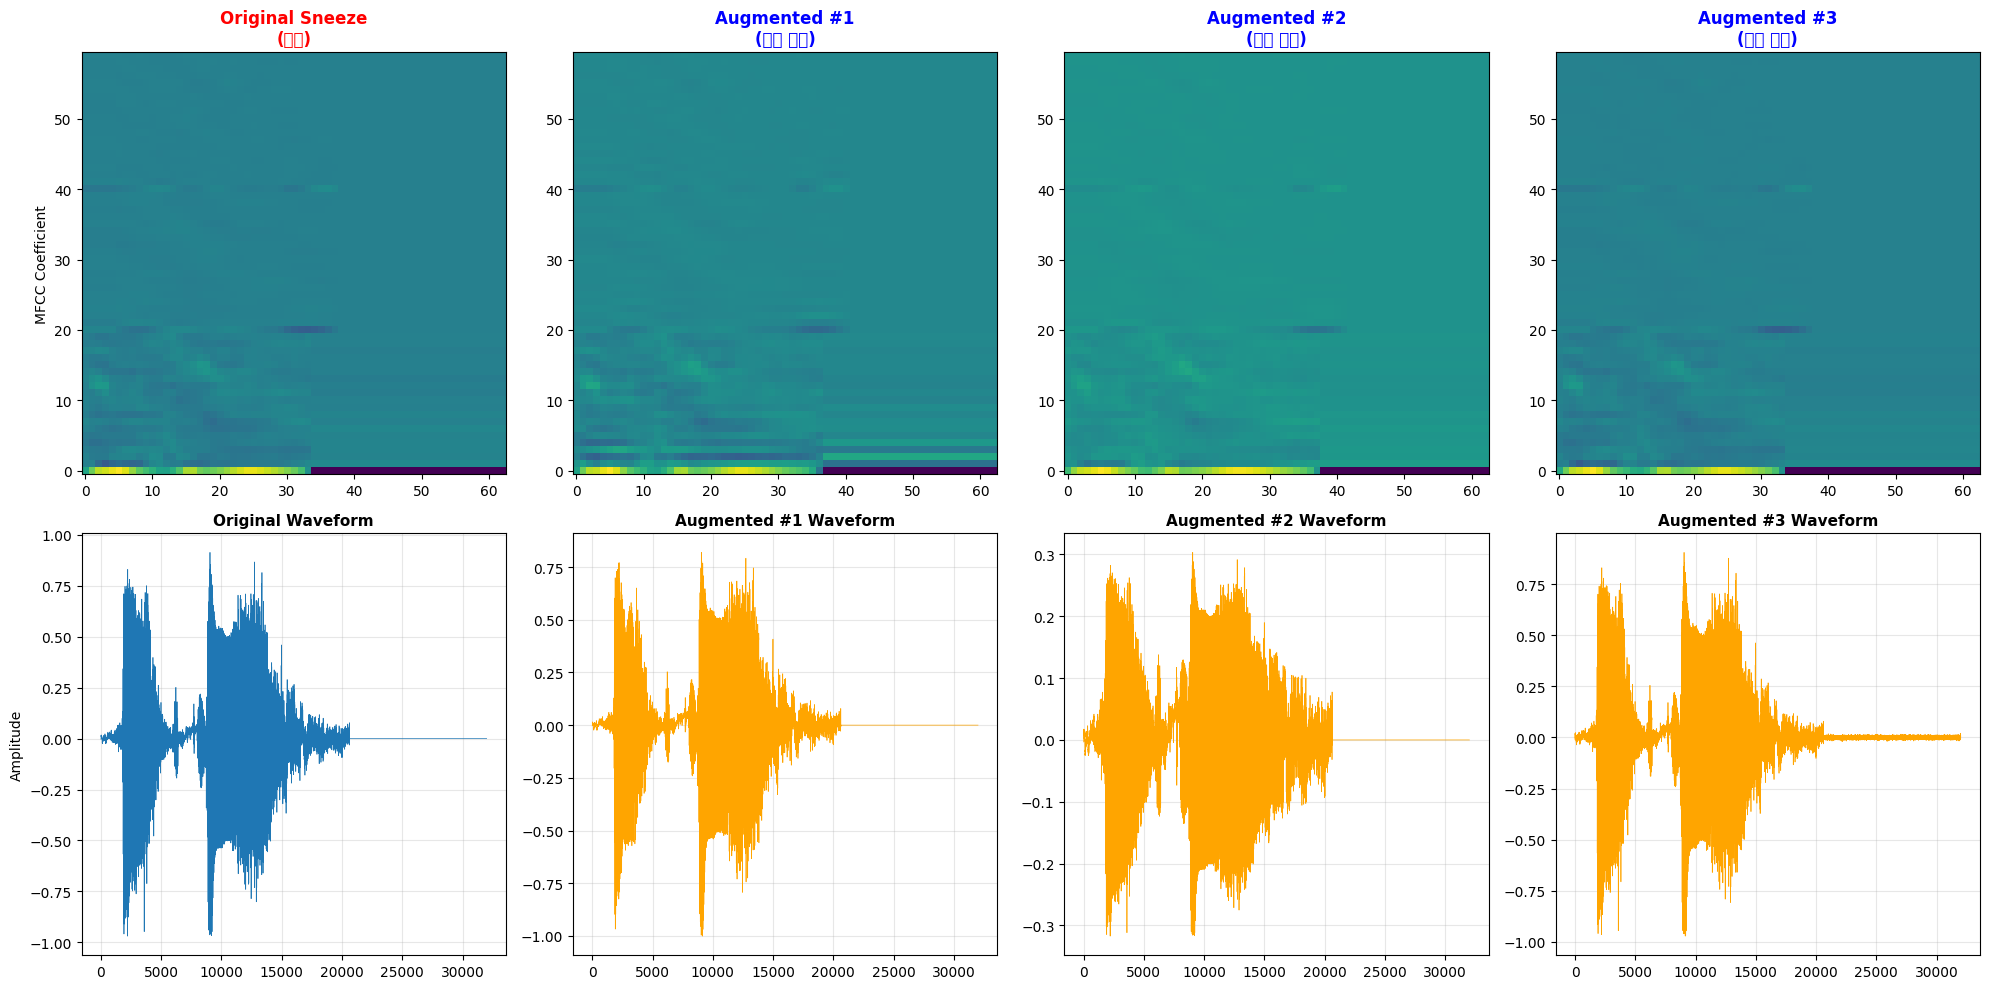


✅ MFCC 특징이 증강에 따라 다양해지는 것을 확인할 수 있습니다.
   이는 모델이 다양한 음향 변형에 대해 더 견고해지도록 합니다.


In [7]:
print("=" * 70)
print("📊 MFCC 특징 비교 시각화")
print("=" * 70)

# 원본과 증강된 샘플 비교
sample_idx = 0
original_audio = sneeze_samples[sample_idx]
augmented_audios = [
    sneeze_aug1[sample_idx],
    sneeze_aug2[sample_idx],
    sneeze_aug3[sample_idx]
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# 원본 MFCC
original_mfcc = extract_mfcc_features(preprocess_audio(original_audio))
axes[0, 0].imshow(original_mfcc, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title('Original Sneeze\n(원본)', fontweight='bold', color='red', fontsize=12)
axes[0, 0].set_ylabel('MFCC Coefficient')

# 증강된 MFCC들
for i, aug_audio in enumerate(augmented_audios):
    aug_mfcc = extract_mfcc_features(preprocess_audio(aug_audio))
    axes[0, i+1].imshow(aug_mfcc, aspect='auto', origin='lower', cmap='viridis')
    axes[0, i+1].set_title(f'Augmented #{i+1}\n(증강 샘플)', fontweight='bold', color='blue', fontsize=12)

# 원본 파형
axes[1, 0].plot(original_audio, linewidth=0.5)
axes[1, 0].set_title('Original Waveform', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)

# 증강된 파형들
for i, aug_audio in enumerate(augmented_audios):
    axes[1, i+1].plot(aug_audio, linewidth=0.5, color='orange')
    axes[1, i+1].set_title(f'Augmented #{i+1} Waveform', fontweight='bold', fontsize=11)
    axes[1, i+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ MFCC 특징이 증강에 따라 다양해지는 것을 확인할 수 있습니다.")
print("   이는 모델이 다양한 음향 변형에 대해 더 견고해지도록 합니다.")

## 7. PyTorch Dataset 및 DataLoader

In [8]:
class SneezeDataset(Dataset):
    def __init__(self, mfcc_list, labels):
        self.mfcc_list = mfcc_list
        self.labels = labels
    
    def __len__(self):
        return len(self.mfcc_list)
    
    def __getitem__(self, idx):
        mfcc = torch.FloatTensor(self.mfcc_list[idx]).unsqueeze(0).to(device)
        label = torch.LongTensor([self.labels[idx]]).to(device)
        return mfcc, label

# 데이터셋 준비
all_mfcc = mfcc_sneeze + mfcc_life
all_labels = [1]*len(mfcc_sneeze) + [0]*len(mfcc_life)

# Train/Val/Test 분할
train_mfcc, temp_mfcc, train_labels, temp_labels = train_test_split(
    all_mfcc, all_labels, test_size=0.3, random_state=SEED, stratify=all_labels
)
val_mfcc, test_mfcc, val_labels, test_labels = train_test_split(
    temp_mfcc, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

# DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(SneezeDataset(train_mfcc, train_labels), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SneezeDataset(val_mfcc, val_labels), batch_size=BATCH_SIZE)
test_loader = DataLoader(SneezeDataset(test_mfcc, test_labels), batch_size=BATCH_SIZE)

print(f"Train: {len(train_mfcc)}, Val: {len(val_mfcc)}, Test: {len(test_mfcc)}")

Train: 9671, Val: 2072, Test: 2073


## 8. 경량 CNN 모델

In [9]:
class LightweightSneezeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Depthwise Separable Conv Blocks
        self.conv1_dw = nn.Conv2d(1, 3, 3, padding=1, groups=1)
        self.conv1_pw = nn.Conv2d(3, 32, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_dw = nn.Conv2d(32, 32, 3, padding=1, groups=32)
        self.conv2_pw = nn.Conv2d(32, 64, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_dw = nn.Conv2d(64, 64, 3, padding=1, groups=64)
        self.conv3_pw = nn.Conv2d(64, 128, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc0 = nn.Linear(128, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1_pw(self.conv1_dw(x))))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2_pw(self.conv2_dw(x))))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3_pw(self.conv3_dw(x))))
        x = self.pool3(x)
        x = self.gap(x).view(x.size(0), -1)
        x = F.relu(self.fc0(x))
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

model = LightweightSneezeCNN().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"모델 파라미터: {total_params:,}개 (~{total_params*4/1024/1024:.2f} MB)")

모델 파라미터: 36,896개 (~0.14 MB)


## 9. 학습 설정

In [10]:
NUM_EPOCHS = 60
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# 🎯 클래스 불균형 처리: Sneeze(Positive) 샘플 부족을 가중치로 보정
# 현재 비율: Sneeze 약 1 : Life Noise 약 3 (3배 증강으로 개선)
total_samples = len(train_mfcc)
sneeze_count = sum(1 for label in train_labels if label == 1)
life_count = sum(1 for label in train_labels if label == 0)

# 역가중치 (클래스 빈도 역으로)
sneeze_weight = total_samples / (2 * sneeze_count) if sneeze_count > 0 else 1.0
life_weight = total_samples / (2 * life_count) if life_count > 0 else 1.0

weights = torch.tensor([life_weight, sneeze_weight], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("=" * 70)
print("🎯 학습 설정 (강화된 데이터 기반)")
print("=" * 70)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"\n📊 훈련 데이터 구성:")
print(f"  Sneeze (클래스 1):    {sneeze_count} 샘플")
print(f"  Life Noise (클래스 0): {life_count} 샘플")
print(f"  총합: {total_samples} 샘플")
print(f"  비율: Sneeze:Life = 1:{life_count/sneeze_count:.1f}")
print(f"\n⚖️  클래스 가중치 (불균형 보정):")
print(f"  Life Noise: {life_weight:.4f}")
print(f"  Sneeze:     {sneeze_weight:.4f}")
print(f"  가중치 비율: 1:{sneeze_weight/life_weight:.2f}")
print("=" * 70)

🎯 학습 설정 (강화된 데이터 기반)
Epochs: 60
Learning Rate: 0.001
Weight Decay: 0.0001

📊 훈련 데이터 구성:
  Sneeze (클래스 1):    2710 샘플
  Life Noise (클래스 0): 6961 샘플
  총합: 9671 샘플
  비율: Sneeze:Life = 1:2.6

⚖️  클래스 가중치 (불균형 보정):
  Life Noise: 0.6947
  Sneeze:     1.7843
  가중치 비율: 1:2.57


## 10. 학습 루프

In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(loader, desc="Train"):
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val"):
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / total, correct / total, all_preds, all_labels

# 🚀 학습 루프 + 상세한 성능 추적
print("=" * 70)
print("🚀 학습 시작 (강화된 데이터 기반)")
print("=" * 70)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_sensitivity': [],  # Sneeze 재현율
    'val_specificity': [],  # Life Noise 특이도
    'val_precision': [],    # 예측된 Sneeze의 정확도
    'val_f1': []            # F1 스코어
}
best_val_acc = 0
patience_counter = 0
best_f1 = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*70}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
    
    # 성능 지표 계산
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    
    from sklearn.metrics import precision_score, f1_score
    
    # True Positive, False Positive, False Negative, True Negative
    tp = np.sum((val_labels == 1) & (val_preds == 1))
    fp = np.sum((val_labels == 0) & (val_preds == 1))
    fn = np.sum((val_labels == 1) & (val_preds == 0))
    tn = np.sum((val_labels == 0) & (val_preds == 0))
    
    # 지표 계산
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Sneeze
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for Life Noise
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_sensitivity'].append(sensitivity)
    history['val_specificity'].append(specificity)
    history['val_precision'].append(precision)
    history['val_f1'].append(f1)
    
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f}, Acc: {val_acc*100:.2f}%")
    print(f"\n📊 상세 지표:")
    print(f"  민감도 (Sensitivity/Recall): {sensitivity*100:.2f}% - Sneeze 탐지율")
    print(f"  특이도 (Specificity):        {specificity*100:.2f}% - Life Noise 거름율")
    print(f"  정밀도 (Precision):          {precision*100:.2f}% - 예측 정확도")
    print(f"  F1 Score:                   {f1:.4f}")
    
    # Best model 저장 (F1 기반)
    if f1 > best_f1:
        best_f1 = f1
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'best_model.pth'))
        patience_counter = 0
        print(f"\n✅ Best model saved! (F1: {f1:.4f}, Acc: {val_acc*100:.2f}%)")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= 10 and epoch > 15:
        print(f"\n⏹️  Early stopping triggered (patience: {patience_counter}/10)")
        break

print(f"\n{'='*70}")
print(f"✅ 학습 완료!")
print(f"{'='*70}")
print(f"Best Val Acc: {best_val_acc*100:.2f}%")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"{'='*70}")

🚀 학습 시작 (강화된 데이터 기반)

Epoch 1/60


Val: 100%|██████████| 65/65 [00:02<00:00, 27.94it/s]


Train Loss: 0.2758, Acc: 90.71%
Val Loss:   0.2030, Acc: 93.24%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 92.94% - Sneeze 탐지율
  특이도 (Specificity):        93.36% - Life Noise 거름율
  정밀도 (Precision):          84.51% - 예측 정확도
  F1 Score:                   0.8852

✅ Best model saved! (F1: 0.8852, Acc: 93.24%)

Epoch 2/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.29it/s]


Train Loss: 0.2006, Acc: 93.39%
Val Loss:   0.2869, Acc: 87.50%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 95.87% - Sneeze 탐지율
  특이도 (Specificity):        84.24% - Life Noise 거름율
  정밀도 (Precision):          70.33% - 예측 정확도
  F1 Score:                   0.8114

Epoch 3/60


Val: 100%|██████████| 65/65 [00:02<00:00, 27.58it/s]


Train Loss: 0.1837, Acc: 93.88%
Val Loss:   0.1632, Acc: 94.06%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 93.63% - Sneeze 탐지율
  특이도 (Specificity):        94.23% - Life Noise 거름율
  정밀도 (Precision):          86.35% - 예측 정확도
  F1 Score:                   0.8984

✅ Best model saved! (F1: 0.8984, Acc: 94.06%)

Epoch 4/60


Val: 100%|██████████| 65/65 [00:02<00:00, 26.36it/s]


Train Loss: 0.1704, Acc: 94.34%
Val Loss:   0.1595, Acc: 94.84%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 93.12% - Sneeze 탐지율
  특이도 (Specificity):        95.51% - Life Noise 거름율
  정밀도 (Precision):          88.98% - 예측 정확도
  F1 Score:                   0.9100

✅ Best model saved! (F1: 0.9100, Acc: 94.84%)

Epoch 5/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.47it/s]


Train Loss: 0.1481, Acc: 94.84%
Val Loss:   0.1430, Acc: 94.16%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 94.15% - Sneeze 탐지율
  특이도 (Specificity):        94.16% - Life Noise 거름율
  정밀도 (Precision):          86.28% - 예측 정확도
  F1 Score:                   0.9004

Epoch 6/60


Val: 100%|██████████| 65/65 [00:05<00:00, 12.34it/s]


Train Loss: 0.1465, Acc: 94.30%
Val Loss:   0.2187, Acc: 95.17%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 86.75% - Sneeze 탐지율
  특이도 (Specificity):        98.46% - Life Noise 거름율
  정밀도 (Precision):          95.64% - 예측 정확도
  F1 Score:                   0.9097

Epoch 7/60


Val: 100%|██████████| 65/65 [00:04<00:00, 14.25it/s]


Train Loss: 0.1279, Acc: 95.12%
Val Loss:   0.1409, Acc: 95.66%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 93.63% - Sneeze 탐지율
  특이도 (Specificity):        96.45% - Life Noise 거름율
  정밀도 (Precision):          91.12% - 예측 정확도
  F1 Score:                   0.9236

✅ Best model saved! (F1: 0.9236, Acc: 95.66%)

Epoch 8/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.50it/s]


Train Loss: 0.1247, Acc: 95.46%
Val Loss:   0.1505, Acc: 95.42%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 94.49% - Sneeze 탐지율
  특이도 (Specificity):        95.77% - Life Noise 거름율
  정밀도 (Precision):          89.71% - 예측 정확도
  F1 Score:                   0.9204

Epoch 9/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.22it/s]


Train Loss: 0.1168, Acc: 95.83%
Val Loss:   0.1187, Acc: 96.09%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 93.46% - Sneeze 탐지율
  특이도 (Specificity):        97.12% - Life Noise 거름율
  정밀도 (Precision):          92.66% - 예측 정확도
  F1 Score:                   0.9306

✅ Best model saved! (F1: 0.9306, Acc: 96.09%)

Epoch 10/60


Val: 100%|██████████| 65/65 [00:02<00:00, 26.75it/s]


Train Loss: 0.1157, Acc: 95.83%
Val Loss:   0.2307, Acc: 95.90%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 88.64% - Sneeze 탐지율
  특이도 (Specificity):        98.73% - Life Noise 거름율
  정밀도 (Precision):          96.44% - 예측 정확도
  F1 Score:                   0.9238

Epoch 11/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.24it/s]


Train Loss: 0.1010, Acc: 96.29%
Val Loss:   0.1581, Acc: 96.62%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 91.22% - Sneeze 탐지율
  특이도 (Specificity):        98.73% - Life Noise 거름율
  정밀도 (Precision):          96.54% - 예측 정확도
  F1 Score:                   0.9381

✅ Best model saved! (F1: 0.9381, Acc: 96.62%)

Epoch 12/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.87it/s]


Train Loss: 0.0897, Acc: 96.58%
Val Loss:   0.2680, Acc: 84.46%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 99.83% - Sneeze 탐지율
  특이도 (Specificity):        78.47% - Life Noise 거름율
  정밀도 (Precision):          64.37% - 예측 정확도
  F1 Score:                   0.7827

Epoch 13/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.00it/s]


Train Loss: 0.0860, Acc: 96.61%
Val Loss:   0.1783, Acc: 95.80%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 87.44% - Sneeze 탐지율
  특이도 (Specificity):        99.06% - Life Noise 거름율
  정밀도 (Precision):          97.32% - 예측 정확도
  F1 Score:                   0.9211

Epoch 14/60


Val: 100%|██████████| 65/65 [00:02<00:00, 27.18it/s]


Train Loss: 0.0841, Acc: 96.93%
Val Loss:   0.1489, Acc: 96.33%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 94.15% - Sneeze 탐지율
  특이도 (Specificity):        97.18% - Life Noise 거름율
  정밀도 (Precision):          92.87% - 예측 정확도
  F1 Score:                   0.9350

Epoch 15/60


Val: 100%|██████████| 65/65 [00:02<00:00, 26.39it/s]


Train Loss: 0.0837, Acc: 96.86%
Val Loss:   0.1061, Acc: 94.84%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 99.48% - Sneeze 탐지율
  특이도 (Specificity):        93.02% - Life Noise 거름율
  정밀도 (Precision):          84.75% - 예측 정확도
  F1 Score:                   0.9153

Epoch 16/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.05it/s]


Train Loss: 0.0854, Acc: 96.71%
Val Loss:   0.0830, Acc: 96.72%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 97.42% - Sneeze 탐지율
  특이도 (Specificity):        96.45% - Life Noise 거름율
  정밀도 (Precision):          91.44% - 예측 정확도
  F1 Score:                   0.9433

✅ Best model saved! (F1: 0.9433, Acc: 96.72%)

Epoch 17/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.50it/s]


Train Loss: 0.0693, Acc: 97.48%
Val Loss:   0.1711, Acc: 91.22%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 99.66% - Sneeze 탐지율
  특이도 (Specificity):        87.93% - Life Noise 거름율
  정밀도 (Precision):          76.28% - 예측 정확도
  F1 Score:                   0.8642

Epoch 18/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.73it/s]


Train Loss: 0.0668, Acc: 97.57%
Val Loss:   0.1099, Acc: 94.35%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 98.80% - Sneeze 탐지율
  특이도 (Specificity):        92.62% - Life Noise 거름율
  정밀도 (Precision):          83.92% - 예측 정확도
  F1 Score:                   0.9075

Epoch 19/60


Val: 100%|██████████| 65/65 [00:03<00:00, 20.36it/s]


Train Loss: 0.0662, Acc: 97.47%
Val Loss:   0.1160, Acc: 97.25%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 94.32% - Sneeze 탐지율
  특이도 (Specificity):        98.39% - Life Noise 거름율
  정밀도 (Precision):          95.80% - 예측 정확도
  F1 Score:                   0.9506

✅ Best model saved! (F1: 0.9506, Acc: 97.25%)

Epoch 20/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.58it/s]


Train Loss: 0.0599, Acc: 97.57%
Val Loss:   0.1097, Acc: 94.31%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 98.97% - Sneeze 탐지율
  특이도 (Specificity):        92.49% - Life Noise 거름율
  정밀도 (Precision):          83.70% - 예측 정확도
  F1 Score:                   0.9069

Epoch 21/60


Val: 100%|██████████| 65/65 [00:02<00:00, 26.80it/s]


Train Loss: 0.0602, Acc: 97.80%
Val Loss:   0.1725, Acc: 96.67%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 90.71% - Sneeze 탐지율
  특이도 (Specificity):        98.99% - Life Noise 거름율
  정밀도 (Precision):          97.23% - 예측 정확도
  F1 Score:                   0.9386

Epoch 22/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.48it/s]


Train Loss: 0.0595, Acc: 97.82%
Val Loss:   0.1143, Acc: 97.01%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 94.32% - Sneeze 탐지율
  특이도 (Specificity):        98.05% - Life Noise 거름율
  정밀도 (Precision):          94.97% - 예측 정확도
  F1 Score:                   0.9465

Epoch 23/60


Val: 100%|██████████| 65/65 [00:02<00:00, 22.57it/s]


Train Loss: 0.0400, Acc: 98.65%
Val Loss:   0.0747, Acc: 97.25%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 98.80% - Sneeze 탐지율
  특이도 (Specificity):        96.65% - Life Noise 거름율
  정밀도 (Precision):          91.99% - 예측 정확도
  F1 Score:                   0.9527

✅ Best model saved! (F1: 0.9527, Acc: 97.25%)

Epoch 24/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.71it/s]


Train Loss: 0.0377, Acc: 98.69%
Val Loss:   0.0965, Acc: 97.01%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.73% - Sneeze 탐지율
  특이도 (Specificity):        97.12% - Life Noise 거름율
  정밀도 (Precision):          92.89% - 예측 정확도
  F1 Score:                   0.9477

Epoch 25/60


Val: 100%|██████████| 65/65 [00:02<00:00, 26.06it/s]


Train Loss: 0.0344, Acc: 98.68%
Val Loss:   0.0766, Acc: 97.49%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 98.28% - Sneeze 탐지율
  특이도 (Specificity):        97.18% - Life Noise 거름율
  정밀도 (Precision):          93.15% - 예측 정확도
  F1 Score:                   0.9564

✅ Best model saved! (F1: 0.9564, Acc: 97.49%)

Epoch 26/60


Val: 100%|██████████| 65/65 [00:03<00:00, 21.54it/s]


Train Loss: 0.0339, Acc: 98.70%
Val Loss:   0.0815, Acc: 96.53%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 98.62% - Sneeze 탐지율
  특이도 (Specificity):        95.71% - Life Noise 거름율
  정밀도 (Precision):          89.95% - 예측 정확도
  F1 Score:                   0.9409

Epoch 27/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.83it/s]


Train Loss: 0.0313, Acc: 98.84%
Val Loss:   0.4443, Acc: 83.64%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 100.00% - Sneeze 탐지율
  특이도 (Specificity):        77.26% - Life Noise 거름율
  정밀도 (Precision):          63.15% - 예측 정확도
  F1 Score:                   0.7742

Epoch 28/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.74it/s]


Train Loss: 0.0326, Acc: 98.79%
Val Loss:   0.1116, Acc: 97.20%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 97.25% - Sneeze 탐지율
  특이도 (Specificity):        97.18% - Life Noise 거름율
  정밀도 (Precision):          93.08% - 예측 정확도
  F1 Score:                   0.9512

Epoch 29/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.31it/s]


Train Loss: 0.0336, Acc: 98.79%
Val Loss:   0.0737, Acc: 96.96%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 98.28% - Sneeze 탐지율
  특이도 (Specificity):        96.45% - Life Noise 거름율
  정밀도 (Precision):          91.51% - 예측 정확도
  F1 Score:                   0.9477

Epoch 30/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.91it/s]


Train Loss: 0.0261, Acc: 99.07%
Val Loss:   0.1691, Acc: 97.10%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 92.77% - Sneeze 탐지율
  특이도 (Specificity):        98.79% - Life Noise 거름율
  정밀도 (Precision):          96.77% - 예측 정확도
  F1 Score:                   0.9473

Epoch 31/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.42it/s]


Train Loss: 0.0287, Acc: 99.00%
Val Loss:   0.1491, Acc: 97.35%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 93.46% - Sneeze 탐지율
  특이도 (Specificity):        98.86% - Life Noise 거름율
  정밀도 (Precision):          96.96% - 예측 정확도
  F1 Score:                   0.9518

Epoch 32/60


Val: 100%|██████████| 65/65 [00:02<00:00, 26.99it/s]


Train Loss: 0.0301, Acc: 98.99%
Val Loss:   0.0974, Acc: 97.83%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.56% - Sneeze 탐지율
  특이도 (Specificity):        98.32% - Life Noise 거름율
  정밀도 (Precision):          95.73% - 예측 정확도
  F1 Score:                   0.9614

✅ Best model saved! (F1: 0.9614, Acc: 97.83%)

Epoch 33/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.03it/s]


Train Loss: 0.0275, Acc: 98.96%
Val Loss:   0.0796, Acc: 97.64%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 97.42% - Sneeze 탐지율
  특이도 (Specificity):        97.72% - Life Noise 거름율
  정밀도 (Precision):          94.33% - 예측 정확도
  F1 Score:                   0.9585

Epoch 34/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.80it/s]


Train Loss: 0.0237, Acc: 99.18%
Val Loss:   0.1008, Acc: 97.88%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.39% - Sneeze 탐지율
  특이도 (Specificity):        98.46% - Life Noise 거름율
  정밀도 (Precision):          96.05% - 예측 정확도
  F1 Score:                   0.9622

✅ Best model saved! (F1: 0.9622, Acc: 97.88%)

Epoch 35/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.50it/s]


Train Loss: 0.0304, Acc: 99.01%
Val Loss:   0.1351, Acc: 95.27%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 99.66% - Sneeze 탐지율
  특이도 (Specificity):        93.56% - Life Noise 거름율
  정밀도 (Precision):          85.78% - 예측 정확도
  F1 Score:                   0.9220

Epoch 36/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.58it/s]


Train Loss: 0.0174, Acc: 99.45%
Val Loss:   0.1185, Acc: 97.64%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 94.32% - Sneeze 탐지율
  특이도 (Specificity):        98.93% - Life Noise 거름율
  정밀도 (Precision):          97.16% - 예측 정확도
  F1 Score:                   0.9572

Epoch 37/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.21it/s]


Train Loss: 0.0160, Acc: 99.46%
Val Loss:   0.1135, Acc: 97.68%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 95.35% - Sneeze 탐지율
  특이도 (Specificity):        98.59% - Life Noise 거름율
  정밀도 (Precision):          96.35% - 예측 정확도
  F1 Score:                   0.9585

Epoch 38/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.23it/s]


Train Loss: 0.0132, Acc: 99.60%
Val Loss:   0.0792, Acc: 97.54%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 98.11% - Sneeze 탐지율
  특이도 (Specificity):        97.32% - Life Noise 거름율
  정밀도 (Precision):          93.44% - 예측 정확도
  F1 Score:                   0.9572

Epoch 39/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.10it/s]


Train Loss: 0.0107, Acc: 99.64%
Val Loss:   0.1760, Acc: 97.25%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 92.43% - Sneeze 탐지율
  특이도 (Specificity):        99.13% - Life Noise 거름율
  정밀도 (Precision):          97.64% - 예측 정확도
  F1 Score:                   0.9496

Epoch 40/60


Val: 100%|██████████| 65/65 [00:02<00:00, 28.01it/s]


Train Loss: 0.0122, Acc: 99.63%
Val Loss:   0.0994, Acc: 97.88%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.73% - Sneeze 탐지율
  특이도 (Specificity):        98.32% - Life Noise 거름율
  정밀도 (Precision):          95.74% - 예측 정확도
  F1 Score:                   0.9623

✅ Best model saved! (F1: 0.9623, Acc: 97.88%)

Epoch 41/60


Val: 100%|██████████| 65/65 [00:02<00:00, 23.72it/s]


Train Loss: 0.0115, Acc: 99.60%
Val Loss:   0.0847, Acc: 97.64%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 97.76% - Sneeze 탐지율
  특이도 (Specificity):        97.59% - Life Noise 거름율
  정밀도 (Precision):          94.04% - 예측 정확도
  F1 Score:                   0.9586

Epoch 42/60


Val: 100%|██████████| 65/65 [00:03<00:00, 21.35it/s]


Train Loss: 0.0071, Acc: 99.74%
Val Loss:   0.1043, Acc: 97.78%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.56% - Sneeze 탐지율
  특이도 (Specificity):        98.26% - Life Noise 거름율
  정밀도 (Precision):          95.57% - 예측 정확도
  F1 Score:                   0.9606

Epoch 43/60


Val: 100%|██████████| 65/65 [00:02<00:00, 27.83it/s]


Train Loss: 0.0055, Acc: 99.79%
Val Loss:   0.1122, Acc: 97.73%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.21% - Sneeze 탐지율
  특이도 (Specificity):        98.32% - Life Noise 거름율
  정밀도 (Precision):          95.72% - 예측 정확도
  F1 Score:                   0.9597

Epoch 44/60


Val: 100%|██████████| 65/65 [00:02<00:00, 24.91it/s]


Train Loss: 0.0073, Acc: 99.74%
Val Loss:   0.1665, Acc: 97.68%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 93.98% - Sneeze 탐지율
  특이도 (Specificity):        99.13% - Life Noise 거름율
  정밀도 (Precision):          97.67% - 예측 정확도
  F1 Score:                   0.9579

Epoch 45/60


Val: 100%|██████████| 65/65 [00:02<00:00, 25.89it/s]


Train Loss: 0.0051, Acc: 99.84%
Val Loss:   0.1258, Acc: 97.59%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 94.66% - Sneeze 탐지율
  특이도 (Specificity):        98.73% - Life Noise 거름율
  정밀도 (Precision):          96.66% - 예측 정확도
  F1 Score:                   0.9565

Epoch 46/60


Val: 100%|██████████| 65/65 [00:02<00:00, 22.20it/s]


Train Loss: 0.0052, Acc: 99.84%
Val Loss:   0.2056, Acc: 97.10%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 91.05% - Sneeze 탐지율
  특이도 (Specificity):        99.46% - Life Noise 거름율
  정밀도 (Precision):          98.51% - 예측 정확도
  F1 Score:                   0.9463

Epoch 47/60


Val: 100%|██████████| 65/65 [00:03<00:00, 19.79it/s]


Train Loss: 0.0054, Acc: 99.82%
Val Loss:   0.1063, Acc: 97.64%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.73% - Sneeze 탐지율
  특이도 (Specificity):        97.99% - Life Noise 거름율
  정밀도 (Precision):          94.93% - 예측 정확도
  F1 Score:                   0.9582

Epoch 48/60


Val: 100%|██████████| 65/65 [00:06<00:00, 10.03it/s]


Train Loss: 0.0041, Acc: 99.89%
Val Loss:   0.1203, Acc: 97.92%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.73% - Sneeze 탐지율
  특이도 (Specificity):        98.39% - Life Noise 거름율
  정밀도 (Precision):          95.90% - 예측 정확도
  F1 Score:                   0.9632

✅ Best model saved! (F1: 0.9632, Acc: 97.92%)

Epoch 49/60


Val: 100%|██████████| 65/65 [00:09<00:00,  6.83it/s]


Train Loss: 0.0029, Acc: 99.88%
Val Loss:   0.1160, Acc: 97.92%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.73% - Sneeze 탐지율
  특이도 (Specificity):        98.39% - Life Noise 거름율
  정밀도 (Precision):          95.90% - 예측 정확도
  F1 Score:                   0.9632

Epoch 50/60


Val: 100%|██████████| 65/65 [00:07<00:00,  8.61it/s]


Train Loss: 0.0030, Acc: 99.91%
Val Loss:   0.1263, Acc: 97.92%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.56% - Sneeze 탐지율
  특이도 (Specificity):        98.46% - Life Noise 거름율
  정밀도 (Precision):          96.06% - 예측 정확도
  F1 Score:                   0.9631

Epoch 51/60


Val: 100%|██████████| 65/65 [00:07<00:00,  8.90it/s]


Train Loss: 0.0021, Acc: 99.94%
Val Loss:   0.1208, Acc: 97.92%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.73% - Sneeze 탐지율
  특이도 (Specificity):        98.39% - Life Noise 거름율
  정밀도 (Precision):          95.90% - 예측 정확도
  F1 Score:                   0.9632

Epoch 52/60


Val: 100%|██████████| 65/65 [00:08<00:00,  7.48it/s]


Train Loss: 0.0027, Acc: 99.92%
Val Loss:   0.1280, Acc: 98.02%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.56% - Sneeze 탐지율
  특이도 (Specificity):        98.59% - Life Noise 거름율
  정밀도 (Precision):          96.39% - 예측 정확도
  F1 Score:                   0.9647

✅ Best model saved! (F1: 0.9647, Acc: 98.02%)

Epoch 53/60


Val: 100%|██████████| 65/65 [00:06<00:00,  9.50it/s]


Train Loss: 0.0023, Acc: 99.92%
Val Loss:   0.1211, Acc: 98.02%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.39% - Sneeze 탐지율
  특이도 (Specificity):        98.66% - Life Noise 거름율
  정밀도 (Precision):          96.55% - 예측 정확도
  F1 Score:                   0.9647

Epoch 54/60


Val: 100%|██████████| 65/65 [00:08<00:00,  7.96it/s]


Train Loss: 0.0015, Acc: 99.97%
Val Loss:   0.1079, Acc: 98.02%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.90% - Sneeze 탐지율
  특이도 (Specificity):        98.46% - Life Noise 거름율
  정밀도 (Precision):          96.08% - 예측 정확도
  F1 Score:                   0.9649

✅ Best model saved! (F1: 0.9649, Acc: 98.02%)

Epoch 55/60


Val: 100%|██████████| 65/65 [00:06<00:00,  9.96it/s]


Train Loss: 0.0025, Acc: 99.90%
Val Loss:   0.1236, Acc: 97.97%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 95.87% - Sneeze 탐지율
  특이도 (Specificity):        98.79% - Life Noise 거름율
  정밀도 (Precision):          96.87% - 예측 정확도
  F1 Score:                   0.9637

Epoch 56/60


Val: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s]


Train Loss: 0.0021, Acc: 99.91%
Val Loss:   0.1144, Acc: 97.88%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.90% - Sneeze 탐지율
  특이도 (Specificity):        98.26% - Life Noise 거름율
  정밀도 (Precision):          95.59% - 예측 정확도
  F1 Score:                   0.9624

Epoch 57/60


Val: 100%|██████████| 65/65 [00:07<00:00,  8.52it/s]


Train Loss: 0.0018, Acc: 99.94%
Val Loss:   0.1167, Acc: 97.97%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.56% - Sneeze 탐지율
  특이도 (Specificity):        98.52% - Life Noise 거름율
  정밀도 (Precision):          96.23% - 예측 정확도
  F1 Score:                   0.9639

Epoch 58/60


Val: 100%|██████████| 65/65 [00:06<00:00, 10.13it/s]


Train Loss: 0.0021, Acc: 99.94%
Val Loss:   0.1138, Acc: 97.97%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.39% - Sneeze 탐지율
  특이도 (Specificity):        98.59% - Life Noise 거름율
  정밀도 (Precision):          96.39% - 예측 정확도
  F1 Score:                   0.9639

Epoch 59/60


Val: 100%|██████████| 65/65 [00:06<00:00, 10.00it/s]


Train Loss: 0.0014, Acc: 99.98%
Val Loss:   0.1306, Acc: 97.97%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.21% - Sneeze 탐지율
  특이도 (Specificity):        98.66% - Life Noise 거름율
  정밀도 (Precision):          96.55% - 예측 정확도
  F1 Score:                   0.9638

Epoch 60/60


Val: 100%|██████████| 65/65 [00:06<00:00, 10.08it/s]

Train Loss: 0.0015, Acc: 99.97%
Val Loss:   0.1241, Acc: 98.02%

📊 상세 지표:
  민감도 (Sensitivity/Recall): 96.39% - Sneeze 탐지율
  특이도 (Specificity):        98.66% - Life Noise 거름율
  정밀도 (Precision):          96.55% - 예측 정확도
  F1 Score:                   0.9647

✅ 학습 완료!
Best Val Acc: 98.02%
Best F1 Score: 0.9649


## 11. 학습 결과 시각화

📈 학습 결과 시각화


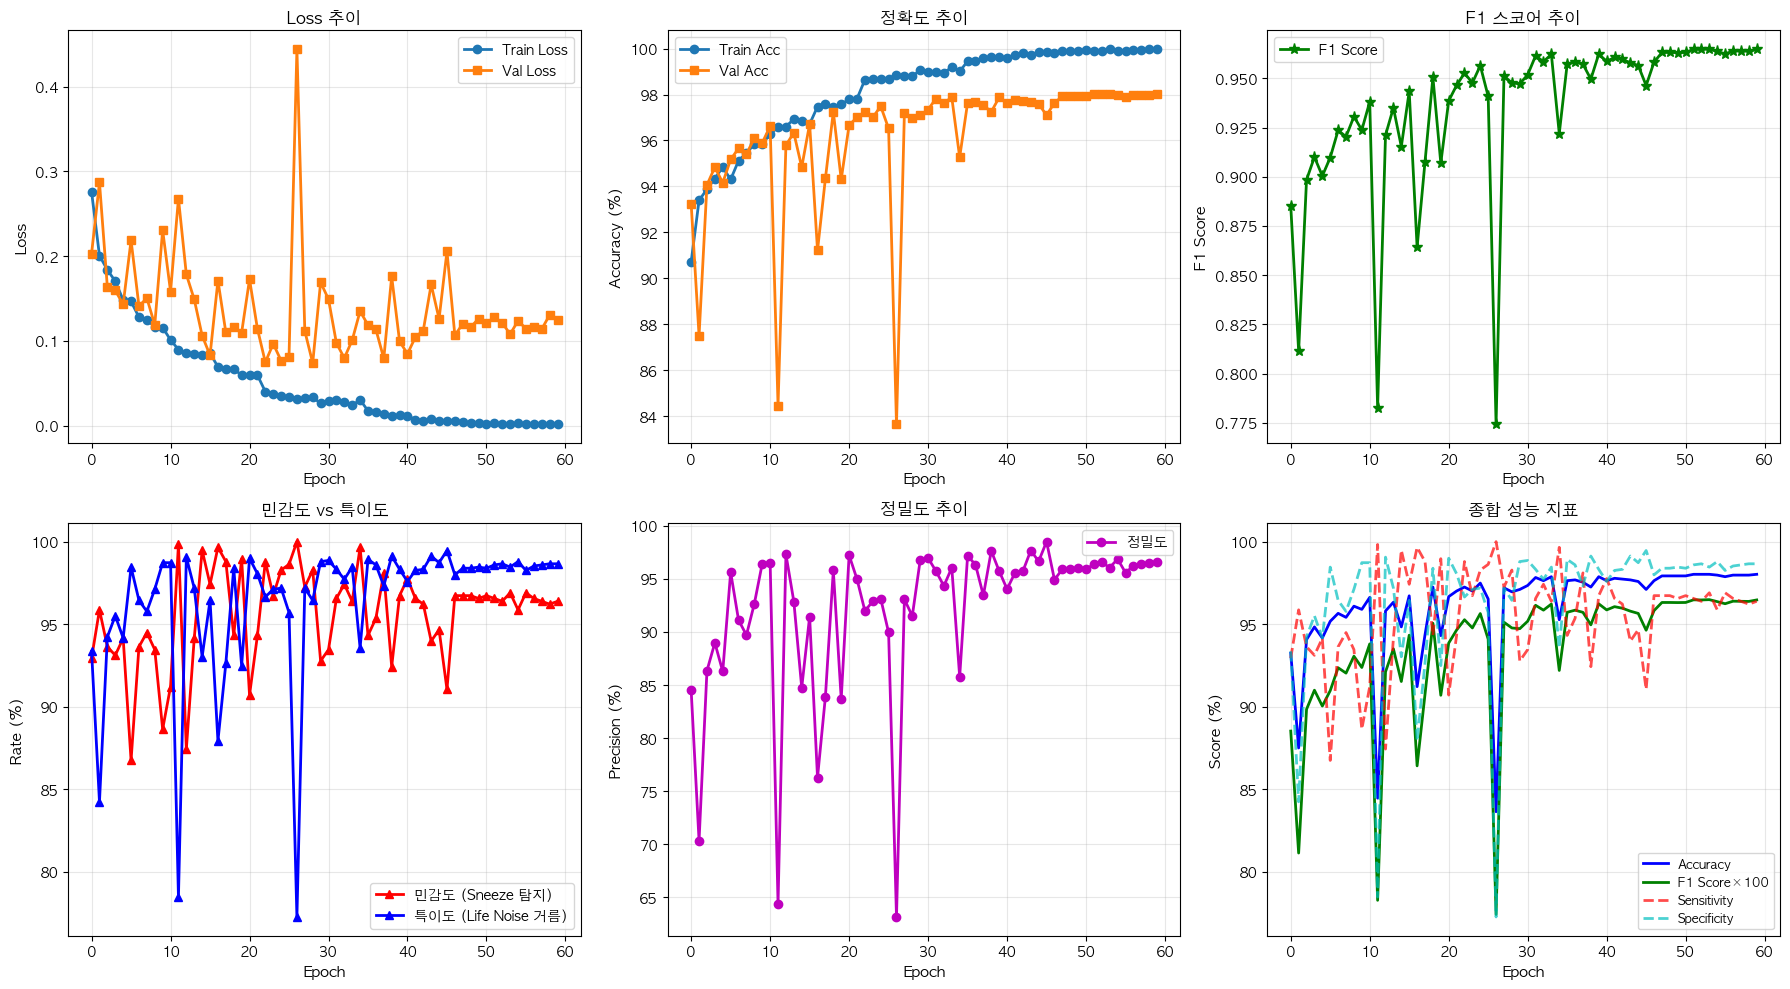


📊 학습 최종 결과 요약
최고 Val Acc: 98.02%
최고 F1 Score: 0.9649
최종 민감도: 96.39%
최종 특이도: 98.66%
최종 정밀도: 96.55%


In [17]:
print("=" * 70)
print("📈 학습 결과 시각화")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Loss 추이
axes[0, 0].plot(history['train_loss'], 'o-', label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], 's-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Loss 추이', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Accuracy 추이
axes[0, 1].plot([a*100 for a in history['train_acc']], 'o-', label='Train Acc', linewidth=2)
axes[0, 1].plot([a*100 for a in history['val_acc']], 's-', label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 1].set_title('정확도 추이', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. F1 Score
axes[0, 2].plot(history['val_f1'], 'g*-', label='F1 Score', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('F1 Score', fontsize=11)
axes[0, 2].set_title('F1 스코어 추이', fontweight='bold', fontsize=12)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. 민감도 vs 특이도
axes[1, 0].plot([s*100 for s in history['val_sensitivity']], 'r^-', label='민감도 (Sneeze 탐지)', linewidth=2)
axes[1, 0].plot([s*100 for s in history['val_specificity']], 'b^-', label='특이도 (Life Noise 거름)', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Rate (%)', fontsize=11)
axes[1, 0].set_title('민감도 vs 특이도', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. 정밀도
axes[1, 1].plot([p*100 for p in history['val_precision']], 'mo-', label='정밀도', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Precision (%)', fontsize=11)
axes[1, 1].set_title('정밀도 추이', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. 모든 지표 종합
axes[1, 2].plot([a*100 for a in history['val_acc']], 'b-', label='Accuracy', linewidth=2)
axes[1, 2].plot([f*100 for f in history['val_f1']], 'g-', label='F1 Score×100', linewidth=2)
axes[1, 2].plot([s*100 for s in history['val_sensitivity']], 'r--', label='Sensitivity', linewidth=2, alpha=0.7)
axes[1, 2].plot([s*100 for s in history['val_specificity']], 'c--', label='Specificity', linewidth=2, alpha=0.7)
axes[1, 2].set_xlabel('Epoch', fontsize=11)
axes[1, 2].set_ylabel('Score (%)', fontsize=11)
axes[1, 2].set_title('종합 성능 지표', fontweight='bold', fontsize=12)
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최종 요약
print("\n" + "=" * 70)
print("📊 학습 최종 결과 요약")
print("=" * 70)
print(f"최고 Val Acc: {max(history['val_acc'])*100:.2f}%")
print(f"최고 F1 Score: {max(history['val_f1']):.4f}")
print(f"최종 민감도: {history['val_sensitivity'][-1]*100:.2f}%")
print(f"최종 특이도: {history['val_specificity'][-1]*100:.2f}%")
print(f"최종 정밀도: {history['val_precision'][-1]*100:.2f}%")
print("=" * 70)

## 12. 테스트 세트 평가

Val: 100%|██████████| 65/65 [00:03<00:00, 20.28it/s]


🧪 테스트 세트 평가 (강화된 데이터 학습 모델)
Test Loss: 0.1066
Test Accuracy: 97.73%

🎯 상세 성능 지표:
  민감도 (Sensitivity/Recall):  97.42% - Sneeze 탐지율
  특이도 (Specificity):         97.86% - Life Noise 거름율
  정밀도 (Precision):           94.65% - 예측 정확도
  F1 Score:                    0.9601

📊 혼동행렬:
  TP (정탐지):      566
  FP (오탐):        32
  FN (미탐):        15
  TN (정거름):      1460

📋 Classification Report:
              precision    recall  f1-score   support

  Life Noise     0.9898    0.9786    0.9842      1492
      Sneeze     0.9465    0.9742    0.9601       581

    accuracy                         0.9773      2073
   macro avg     0.9682    0.9764    0.9721      2073
weighted avg     0.9777    0.9773    0.9774      2073



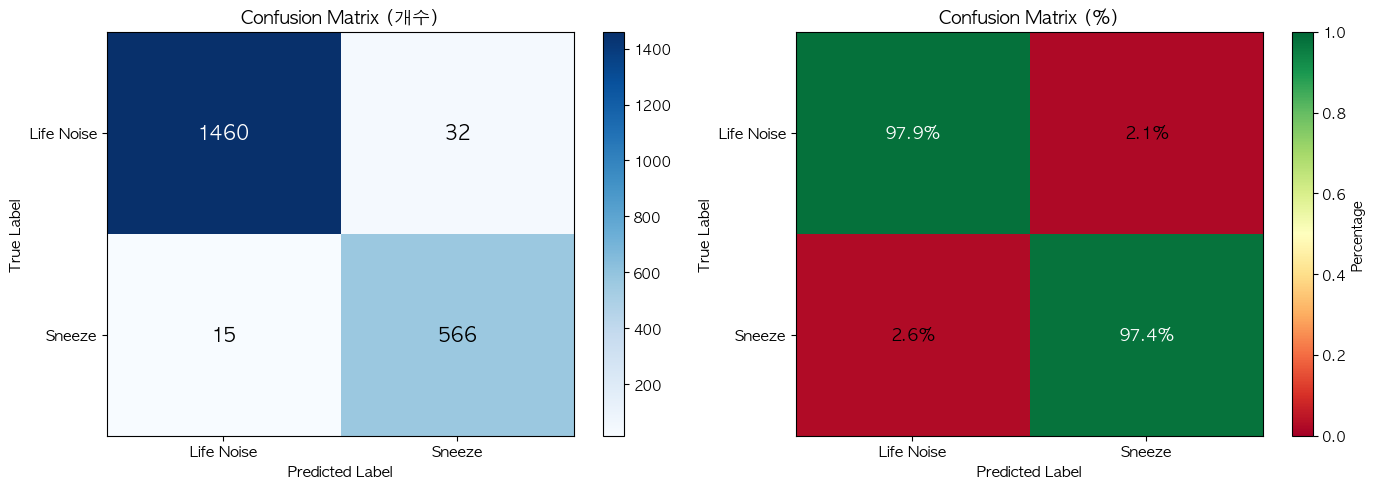

In [18]:
# Best model 로드
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_model.pth')))

# 테스트
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

print("=" * 70)
print("🧪 테스트 세트 평가 (강화된 데이터 학습 모델)")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# 상세 지표
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

tp = np.sum((test_labels == 1) & (test_preds == 1))
fp = np.sum((test_labels == 0) & (test_preds == 1))
fn = np.sum((test_labels == 1) & (test_preds == 0))
tn = np.sum((test_labels == 0) & (test_preds == 0))

test_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
test_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
test_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
test_f1 = 2 * (test_precision * test_sensitivity) / (test_precision + test_sensitivity) if (test_precision + test_sensitivity) > 0 else 0

print(f"\n🎯 상세 성능 지표:")
print(f"  민감도 (Sensitivity/Recall):  {test_sensitivity*100:.2f}% - Sneeze 탐지율")
print(f"  특이도 (Specificity):         {test_specificity*100:.2f}% - Life Noise 거름율")
print(f"  정밀도 (Precision):           {test_precision*100:.2f}% - 예측 정확도")
print(f"  F1 Score:                    {test_f1:.4f}")

print(f"\n📊 혼동행렬:")
print(f"  TP (정탐지):      {tp}")
print(f"  FP (오탐):        {fp}")
print(f"  FN (미탐):        {fn}")
print(f"  TN (정거름):      {tn}")

print(f"\n📋 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Life Noise', 'Sneeze'], digits=4))

# Confusion Matrix 시각화
cm = confusion_matrix(test_labels, test_preds)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix 히트맵
im = axes[0].imshow(cm, cmap='Blues', aspect='auto')
axes[0].set_title('Confusion Matrix (개수)', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=axes[0])
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Life Noise', 'Sneeze'], fontsize=11)
axes[0].set_yticklabels(['Life Noise', 'Sneeze'], fontsize=11)
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f'{cm[i, j]}', ha='center', va='center', 
                    fontsize=14, fontweight='bold', color='white' if cm[i, j] > cm.max()/2 else 'black')
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_ylabel('True Label', fontsize=11)

# Normalized Confusion Matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im2 = axes[1].imshow(cm_norm, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (%)', fontsize=13, fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='Percentage')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Life Noise', 'Sneeze'], fontsize=11)
axes[1].set_yticklabels(['Life Noise', 'Sneeze'], fontsize=11)
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f'{cm_norm[i, j]*100:.1f}%', ha='center', va='center', 
                    fontsize=12, fontweight='bold', color='white' if cm_norm[i, j] > 0.5 else 'black')
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)

plt.tight_layout()
plt.show()

print("=" * 70)

## 13. 모델 Export

In [14]:
# TorchScript
model.eval()
example = torch.randn(1, 1, 60, 63).to(device)
traced = torch.jit.trace(model, example)
traced.save(os.path.join(MODEL_SAVE_PATH, 'sneeze_model_scripted.pt'))

# ONNX
torch.onnx.export(
    model, example,
    os.path.join(MODEL_SAVE_PATH, 'sneeze_model.onnx'),
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}}
)

print("모델 저장 완료!")
print(f"  - PyTorch: best_model.pth")
print(f"  - TorchScript: sneeze_model_scripted.pt")
print(f"  - ONNX: sneeze_model.onnx")

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_71118/3849052523.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


모델 저장 완료!
  - PyTorch: best_model.pth
  - TorchScript: sneeze_model_scripted.pt
  - ONNX: sneeze_model.onnx


## 14. 추론 예제

In [15]:
def predict_audio(model, audio_path, device):
    model.eval()
    audio = load_audio(audio_path)
    audio = preprocess_audio(audio)
    mfcc = extract_mfcc_features(audio)
    mfcc_tensor = torch.FloatTensor(mfcc).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(mfcc_tensor)
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
        conf = prob[0][pred].item()
    
    return pred, conf

# 테스트
test_file = os.path.join(SNEEZE_AUDIO_PATH, os.listdir(SNEEZE_AUDIO_PATH)[0])
if test_file.endswith('.wav'):
    pred, conf = predict_audio(model, test_file, device)
    label = "Sneeze" if pred == 1 else "Life Noise"
    print(f"파일: {os.path.basename(test_file)}")
    print(f"예측: {label} (신뢰도: {conf*100:.2f}%)")

파일: sneeze299.wav
예측: Sneeze (신뢰도: 100.00%)


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3